#**Problem: Smoke and Fire Classification from Images**
The problem involves classifying images into two categories: "Smoke" and "Fire." This image classification task is typically addressed using machine learning or deep learning techniques. The goal is to develop a model that can accurately distinguish between images containing smoke, images containing fire

# **Pre Processing and Data Visualization**

## **Importing Libraries**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import keras
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import Model, Sequential,load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications import Xception
from keras.applications import DenseNet121, DenseNet169, DenseNet201
from keras.optimizers import Adam, RMSprop,SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from PIL import Image
import cv2
import os
import glob
import itertools

In [ ]:
# mounting the google drive with the notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Train and Test Set**

In [ ]:
# Labels assigned for classification
labels = ['Fire', 'Smoke']

In [ ]:
# loading data from google drive
path = '/content/drive/MyDrive/Colab NoteBooks/Transfer_Learning/Dataset'
X_train = []
y_train = []
X_test = []
y_test = []

image_size = 224 #image size is 224 X 224 X 3 (224 X 224 are dimensions of the image while 3 channels of colored RGB image)

# loading data from drive into x_train and y_train lists

for i in labels:
    folderPath = os.path.join(path,'Train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #read image in 3 channel (RGB)
        img = cv2.resize(img,(image_size, image_size)) # resizing the image on to the standard size (224)
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join(path,'Test',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)

#type cast onto numpy array, due to model requirements
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


**EDA**

Claswise distribution in Train set


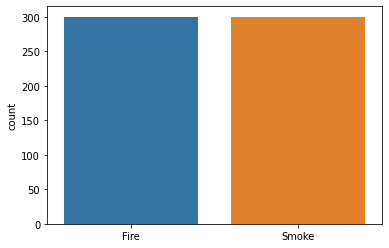

In [ ]:
# plotting Data Distribution Classwise in Train Data
print("Claswise distribution in Train set")
sns.countplot(x = y_train)
plt.show()
# below graph shows balanced dataset

Claswise distribution in Test set


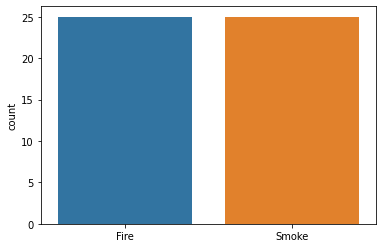

In [ ]:
# plotting Data Distribution Classwise in Test Data
print("Claswise distribution in Test set")
sns.countplot(x = y_test)
plt.show()

## **Label Encoding**

In [ ]:
#For each unique category in y_train, it will create a new binary column, where 1 indicates the presence of that category, and 0 indicates absence.
label_dummies = pd.get_dummies(y_train)
y_train =  label_dummies.values.argmax(1)
print(pd.unique(y_train))

# printing number of instances and dimensions of training data
print ("X train shape",X_train.shape)
print ("y train shape",y_train.shape)

[0 1]
X train shape (600, 224, 224, 3)
y train shape (600,)


In [ ]:
#For each unique category in y_train, it will create a new binary column, where 1 indicates the presence of that category, and 0 indicates absence.
label_dummies = pd.get_dummies(y_test)
y_test =  label_dummies.values.argmax(1)
print(pd.unique(y_test))

# printing number of instances and dimensions of test data
print ("X test shape",X_test.shape)
print ("y test shape",y_test.shape)

[0 1]
X test shape (50, 224, 224, 3)
y test shape (50,)


In [ ]:
# normalize dataset, preprocessing step: it will help in good model learning
train_x = X_train.astype('float32')
test_x = X_test.astype('float32')
train_x /= 255
test_x /= 255

train_y = y_train
test_y = y_test

In [ ]:
from sklearn.utils import shuffle
# shuffle dataset
# using the shuffle function to randomly shuffle the order of your training data to ensure that the model does not learn patterns based on the order of the data
train_x, train_y = shuffle(train_x, train_y, random_state=101)
test_x, test_y = shuffle(test_x, test_y, random_state=101)

In [ ]:
print("x train=",train_x.shape)
print("y train=",train_y.shape)

print("x test=",test_x.shape)
print("y test=",test_y.shape)

x train= (600, 224, 224, 3)
y train= (600,)
x test= (50, 224, 224, 3)
y test= (50,)


In [ ]:
#When you want split the dataset through code
#train_x, test_x, train_y, test_y=train_test_split(dataset,labels,test_size=0.2,random_state = 3, shuffle=True)

## **Visualization**

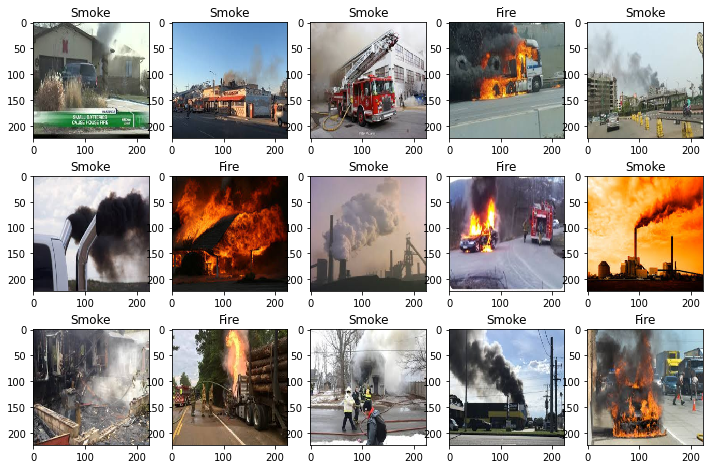

In [ ]:
# Display first 15 instances and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if train_y[i] == 0:
        ax.title.set_text('Fire')
    else:
        ax.title.set_text('Smoke')
    plt.imshow(train_x[i], interpolation='nearest')
plt.show()

# **Training Phase**

## **Pre-trained Model: EfficientNetB0**

####  Fine Tuning | Feature extraction:
We can use a pre-trained model as a feature extraction mechanism. What we can do is that we can remove the output layer ( the one which gives the probabilities for being in each of the 1000 classes) and then use the entire network as a fixed feature extractor for the new data set.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
#load pre-trained EfficientNet weights
#imagenet is a pretrained model trained on huge image data
#https://www.image-net.org/

efficient_model = EfficientNetB0(
                                 weights='imagenet', # "None' if (random initialization), & "imagenet" if (pre-training on ImageNet), or the path to the weights file to be loaded
                                 include_top=False, # whether to include the fully-connected layer at the top of the network
                                 input_shape=(224,224,3),
                                 pooling=None, # Optional pooling mode for feature extraction when include_top is False. Defaults to None.
                                 classes=2, # Optional number of classes to classify images into, only to be specified if include_top is True.
                                 )

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
# adding our custom FC layers
model1 = efficient_model.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
#adding dropuout layer
#model1 = tf.keras.layers.Dropout(rate=0.2)(model1)
model1 = tf.keras.layers.Dense(1,activation='sigmoid')(model1)  #Here If we have multiclass problem say 4 classes then change No.of classes 1 to 4 & activation function from Sigmoid to softmax
# this is the model we will train
model1 = tf.keras.models.Model(inputs=efficient_model.input, outputs = model1)

In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

In [ ]:
model1.compile(
    loss='binary_crossentropy', # Binary_crossentropy loss function is used for Binary classification problem, if we are dealing with multiclass classification problem we can use categorical_crossentropy & sparse_categorical_crossentropy
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
h = model1.fit(train_x,train_y,
              validation_split=0.1,
              shuffle = True,
              batch_size=16,
              epochs = 20,
              verbose=1)

Epoch 1/20
27/27 [==============================] - 12s 152ms/step - loss: 0.7256 - accuracy: 0.4745 - val_loss: 0.6876 - val_accuracy: 0.6042
Epoch 2/20
27/27 [==============================] - 2s 57ms/step - loss: 0.7113 - accuracy: 0.4537 - val_loss: 0.6974 - val_accuracy: 0.3750
Epoch 3/20
27/27 [==============================] - 2s 56ms/step - loss: 0.7025 - accuracy: 0.5162 - val_loss: 0.7010 - val_accuracy: 0.3958
Epoch 4/20
27/27 [==============================] - 2s 62ms/step - loss: 0.7048 - accuracy: 0.4560 - val_loss: 0.6951 - val_accuracy: 0.3958
Epoch 5/20
27/27 [==============================] - 2s 61ms/step - loss: 0.6976 - accuracy: 0.5093 - val_loss: 0.7019 - val_accuracy: 0.3958
Epoch 6/20
27/27 [==============================] - 2s 56ms/step - loss: 0.6904 - accuracy: 0.5208 - val_loss: 0.6942 - val_accuracy: 0.3333
Epoch 7/20
27/27 [==============================] - 1s 55ms/step - loss: 0.7013 - accuracy: 0.4977 - val_loss: 0.7035 - val_accuracy: 0.3958
Epoch 8/20


#### Fine Tuning - Use the Architecture of the pre-trained model:
What we can do is that we use architecture of the model while we initialize all the weights randomly and train the model according to our dataset again.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
#load pre-trained EfficientNet weights
efficient_model_b0 = EfficientNetB0(
                                 weights=None, # "None' if (random initialization), & "imagenet" if (pre-training on ImageNet), or the path to the weights file to be loaded
                                 include_top=False, # whether to include the fully-connected layer at the top of the network
                                 input_shape=(224,224,3),
                                 pooling=None, # Optional pooling mode for feature extraction when include_top is False. Defaults to None.
                                 )

In [ ]:
# adding our custom FC layers
model0 = efficient_model_b0.output
model0 = tf.keras.layers.GlobalAveragePooling2D()(model0)
model0 = tf.keras.layers.Dropout(rate=0.2)(model0)
model0 = tf.keras.layers.Dense(1,activation='sigmoid')(model0) #Here If we have multiclass problem say 4 classes then change No.of classes 1 o 4 & activation function from Sigmoid to softmax
# this is the model we will train
model0 = tf.keras.models.Model(inputs=efficient_model_b0.input, outputs = model0)

In [ ]:
model0.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
model0.compile(
    loss='binary_crossentropy', # Binary_crossentropy loss function is used for Binary classification problem, if we are dealing with multiclass classification problem we can use categorical_crossentropy & sparse_categorical_crossentropy
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
his = model0.fit(train_x,train_y,
                    validation_split=0.1,
                    shuffle = True,
                    batch_size=16,
                    epochs = 20,
                    verbose=1)

Epoch 1/20
34/34 [==============================] - 37s 238ms/step - loss: 0.6817 - accuracy: 0.5648 - val_loss: 0.6769 - val_accuracy: 0.6000
Epoch 2/20
34/34 [==============================] - 6s 166ms/step - loss: 0.5430 - accuracy: 0.7167 - val_loss: 0.6731 - val_accuracy: 0.6000
Epoch 3/20
34/34 [==============================] - 6s 165ms/step - loss: 0.4462 - accuracy: 0.7981 - val_loss: 0.6916 - val_accuracy: 0.6000
Epoch 4/20
34/34 [==============================] - 6s 166ms/step - loss: 0.4080 - accuracy: 0.8315 - val_loss: 0.7121 - val_accuracy: 0.6000
Epoch 5/20
34/34 [==============================] - 6s 166ms/step - loss: 0.3335 - accuracy: 0.8519 - val_loss: 0.7646 - val_accuracy: 0.6000
Epoch 6/20
34/34 [==============================] - 6s 166ms/step - loss: 0.2600 - accuracy: 0.9056 - val_loss: 1.1504 - val_accuracy: 0.6000
Epoch 7/20
34/34 [==============================] - 6s 169ms/step - loss: 0.2996 - accuracy: 0.8815 - val_loss: 0.8430 - val_accuracy: 0.6000
Epoch

#### Fine Tuning - Train some layers while freeze others:
Another way to use a pre-trained model is to train is partially. What we can do is we keep the weights of initial layers of the model frozen while we retrain only the higher layers. We can try and test as to how many layers to be frozen and how many to be trained.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
#load pre-trained EfficientNet weights
efficientNet_model = EfficientNetB0(
                                 weights='imagenet', # "None' if (random initialization), & "imagenet" if (pre-training on ImageNet), or the path to the weights file to be loaded
                                 include_top=False, # whether to include the fully-connected layer at the top of the network
                                 input_shape=(224,224,3),
                                 pooling=None, # Optional pooling mode for feature extraction when include_top is False. Defaults to None.
                                 )

In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(efficientNet_model.layers):
   print(i, layer.name)

0 input_3
1 rescaling_2
2 normalization_2
3 tf.math.truediv_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [ ]:
# the first 162 layers and unfreeze the rest:
for layer in efficientNet_model.layers[:162]:  #freezing layers before 162 layers
   layer.trainable = False
for layer in efficientNet_model.layers[162:]:  #training layers after 162 layers
   layer.trainable = True

In [ ]:
# adding our custom FC layers
fine_tuned_efficientNet_model = efficientNet_model.output
fine_tuned_efficientNet_model = tf.keras.layers.GlobalAveragePooling2D()(fine_tuned_efficientNet_model)
fine_tuned_efficientNet_model = tf.keras.layers.Dropout(rate=0.3)(fine_tuned_efficientNet_model)
fine_tuned_efficientNet_model = tf.keras.layers.Dense(1,activation='sigmoid')(fine_tuned_efficientNet_model) #Here If we have multiclass problem say 4 classes then change No.of classes 1 o 4 & activation function from Sigmoid to softmax
# this is the model we will train
fine_tuned_efficientNet_model = tf.keras.models.Model(inputs=efficientNet_model.input, outputs = fine_tuned_efficientNet_model)

In [ ]:
fine_tuned_efficientNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [ ]:
fine_tuned_efficientNet_model.compile(
    loss='binary_crossentropy', # Binary_crossentropy loss function is used for Binary classification problem, if we are dealing with multiclass classification problem we can use categorical_crossentropy & sparse_categorical_crossentropy
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

##### **Training The Model**

In [ ]:
history = fine_tuned_efficientNet_model.fit(train_x,train_y,
                                            validation_split=0.1,
                                            shuffle = True,
                                            batch_size=16,
                                            epochs = 50,
                                            verbose=1)

Epoch 1/50
34/34 [==============================] - 10s 96ms/step - loss: 0.6961 - accuracy: 0.5519 - val_loss: 0.6979 - val_accuracy: 0.4000
Epoch 2/50
34/34 [==============================] - 2s 55ms/step - loss: 0.6036 - accuracy: 0.6667 - val_loss: 0.7108 - val_accuracy: 0.4000
Epoch 3/50
34/34 [==============================] - 2s 56ms/step - loss: 0.5902 - accuracy: 0.6778 - val_loss: 0.7404 - val_accuracy: 0.4000
Epoch 4/50
34/34 [==============================] - 2s 55ms/step - loss: 0.5530 - accuracy: 0.6778 - val_loss: 0.7588 - val_accuracy: 0.4000
Epoch 5/50
34/34 [==============================] - 2s 55ms/step - loss: 0.4982 - accuracy: 0.7333 - val_loss: 0.7642 - val_accuracy: 0.4000
Epoch 6/50
34/34 [==============================] - 2s 71ms/step - loss: 0.5162 - accuracy: 0.7111 - val_loss: 0.7587 - val_accuracy: 0.4000
Epoch 7/50
34/34 [==============================] - 2s 57ms/step - loss: 0.5064 - accuracy: 0.7185 - val_loss: 0.7460 - val_accuracy: 0.4000
Epoch 8/50
3

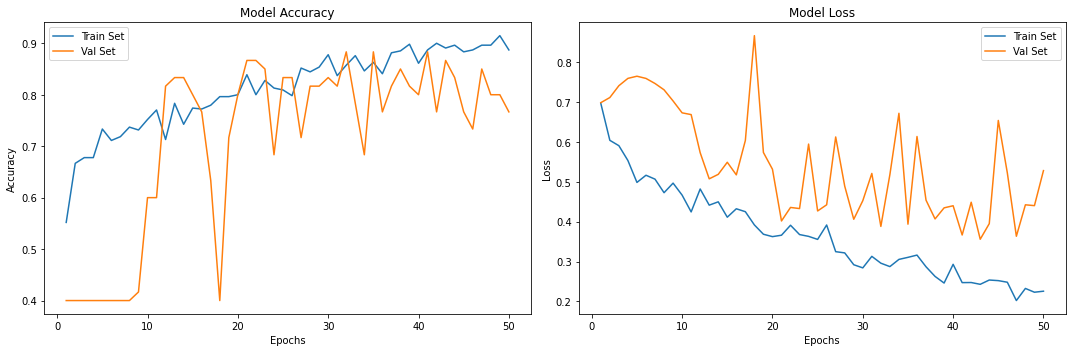

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()
# Graphs: Model is not learning by observing the stocahstic (random) behaviour of validation accuracy and loss

In [ ]:
# save architecture + weights of trained model
fine_tuned_efficientNet_model.save('/content/drive/MyDrive/Colab NoteBooks/Transfer_Learning/saved model/fine_tuned_efficientNet_model.h5')

#**Testing Phase**

## **Suitable Evaluation Measures - Accuracy, Precision, Recall, Confusion Matrix**

### **Prediction**

In [ ]:
# if activation function is sigmoid and Binary classification probelm use this code for prediction on Test data

# for sigmoid
predictions = (fine_tuned_efficientNet_model.predict(test_x) > 0.5).astype("int32")
y_pred = predictions.flatten()
print(y_pred)

2/2 [==============================] - 2s 455ms/step
[1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1
 1 0 1 1 1 1 0 1 1 0 0 0 1]


In [ ]:
# for softmax ..> If we are dealing with Multiclass problem and activation function is Softmax
# pred=model.predict(test_x)
# y_pred=np.argmax(pred,axis=1)

# loss, acc = model.evaluate(test_x, test_y, verbose = 0)
# print("\nEvaluation on test data: ", acc * 100)

### **Evaluation**

In [ ]:
loss,acc = fine_tuned_efficientNet_model.evaluate(test_x,test_y,verbose = 1)
print("Test Accuracy: ",np.round(acc*100,2))

2/2 [==============================] - 0s 55ms/step - loss: 0.4849 - accuracy: 0.7600
Test Accuracy:  76.0


### **Confusion Matrix**

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

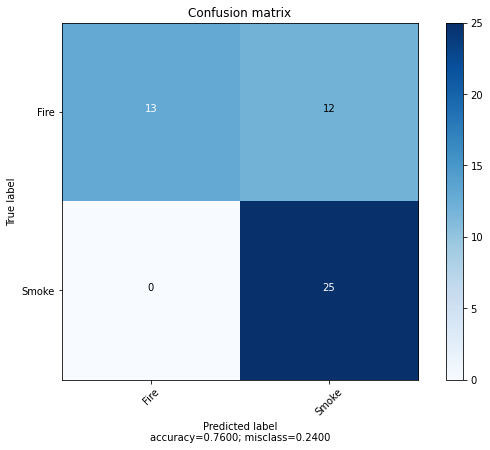

In [ ]:
confusion_mtx = confusion_matrix(test_y, y_pred)
cm_plot_labels = ['Fire','Smoke']
cm = plot_confusion_matrix(confusion_mtx, target_names = cm_plot_labels, normalize=False)

### **Classification Report**

In [ ]:
print(classification_report(test_y,y_pred, target_names = cm_plot_labels, digits = 4))

              precision    recall  f1-score   support

        Fire     1.0000    0.5200    0.6842        25
       Smoke     0.6757    1.0000    0.8065        25

    accuracy                         0.7600        50
   macro avg     0.8378    0.7600    0.7453        50
weighted avg     0.8378    0.7600    0.7453        50



# **Application Phase**

In [ ]:
#Loading Un-seen Image
img_path = '/content/drive/MyDrive/Colab NoteBooks/Transfer_Learning/Data for Application Phase/Fire (2).jpg'

In [ ]:
image_size = 224

image = cv2.imread(img_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(image_size, image_size))

image_array = np.array(image)
#normalization
image_array = image_array.astype('float32')
image_array = image_array / 255

## Load the trained model

In [ ]:
fine_tuned_efficientNet_modelb0 = load_model('/content/drive/MyDrive/Colab NoteBooks/Transfer_Learning/saved model/fine_tuned_efficientNet_model.h5')

## Prediction on Unseen Instance

In [ ]:
image_array = np.expand_dims(image_array, axis=0)
prediction = fine_tuned_efficientNet_modelb0.predict(image_array)
prediction = np.argmax(prediction,axis=1)
print(prediction)

1/1 [==============================] - 1s 1s/step
[0]


 

Trained Model Prediction
 + ============================== +
 |                                |
           Class : Fire       
 |                                |
 + ============================== +


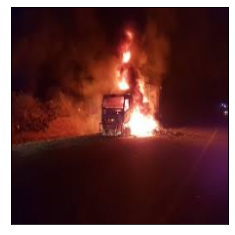

In [ ]:
if prediction[0] == 0:
  print('\033[1m',"\n\nTrained Model Prediction")
  print('\033[1m',"+","="*30,"+")
  print('\033[1m',"|"," "*30,"|\n           Class : Fire       \n","|                                |")
  print('\033[1m',"+","="*30,"+")
  plt.imshow(image)
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()

else:
  print('\033[1m',"\n\nTrained Model Prediction")
  print('\033[1m',"+","="*30,"+")
  print('\033[1m',"|"," "*30,"|\n           Class : Smoke       \n","|                                |")
  print('\033[1m',"+","="*30,"+")
  plt.imshow(image)
  plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
  plt.show()